In [1]:
import matplotlib.pyplot
import numpy
import itertools
import copy

In [2]:
#
#  0--t[0]--1--t[1]--2--t[2]-- ... --N-2--t[N-2]--N-1
#  |        |        |                |            |
# v[0]     v[1]     v[2]           v[N-2]        v[N-1]
#  |        |        |                |            |
#  N       N+1      N+2        ...  2*N-2        2*N-1
#

In [3]:
# N: number of upper sites (leads to 2*N total sites)
# u: number of up electrons
# d: number of down electrons
# t: list of upper site connection energies (N-1 entries)
# v: list of upper and lower connection energies (N energies)
# e: electron interaction energy

class hamiltonian:
    def __init__(self, N, u, d, t, v, e, elow):
        """
        Assigns input variables, makes and sorts states, and makes Hamiltonian matrix.
        """
        self.N= N
        self.u= u
        self.d= d
        self.t= t
        self.v= v
        self.e= e
        self.e= elow
        self.makestates()
        self.sortstates()
        self.slength= len(self.states)
        self.makehamiltonian()
        self.evals, self.evecs= numpy.linalg.eig(self.H)
        self.makebasis()
    def repeat(self, x, i, j):
        """
        Given a list and two nonnegative integers, this function returns True
        if the list contains repeat elements between the integers (including the
        first integer but not the second), and False if there are no repeat elements.
        """
        setx= set(x[i: j])
        return len(x[i: j])!= len(setx)
    def permuted(self, x, y):
        """
        Given two states, this function returns True if their corresponding up and down
        parts are permutations of eachother and False if not. For example, for N=4 u=3 d=2,
        given [2, 1, 3, 6, 7] and [3, 1, 2, 7, 6] this function would return True.
        """
        upxset= set(x[:self.u])
        upyset= set(y[:self.u])
        downxset= set(x[self.u: self.u+ self.d])
        downyset= set(y[self.u: self.u+ self.d])
        return upxset==upyset and downxset==downyset
    def makestates(self):
        """
        Creates a list of states for the input system.
        Note: this list of states is not sorted.
        """
        x= [i for i in range(2*self.N)]
        z= itertools.product(x, repeat= self.u+ self.d)
        z= list(z)
        for a in z[:]:
            if(self.repeat(a, 0, self.u) or self.repeat(a, self.u, self.u+self.d)):
                z.remove(a)
        dummyz= z        
        for a in dummyz:
            for b in dummyz:
                if((a!=b) and self.permuted(a, b)):
                    z.remove(b)
        self.states= [list(a) for a in z]
    def sortstate(self, s):
        """
        Takes as an input a state, and returns a state with incrementing up spin
        values and incrementing down spin values.
        For example, for N=4 u=3 d=2, inputting [4, 2, 1, 5, 4] would return
        [1, 2, 4, 4, 5].
        """
        ss= copy.copy(s)
        sortups= ss[:self.u]
        sortups.sort()
        sortdowns= ss[self.u: self.u+ self.d]
        sortdowns.sort()
        return sortups+ sortdowns
    def sortstates(self):
        """
        Takes the list of states and sorts each state in that list according
        to the sortstate function.
        """
        sorting= [self.sortstate(a) for a in self.states]
        sorting.sort()
        self.states= sorting
    def sindex(self, s):
        """
        Takes as an input a state, and returns that states indexing number.
        Returns the same indexing number for indistinguishable states.
        For example, if N=4 u=2 d=1, then [2, 6, 7] and [6, 2, 7] have
        the same indexing number.
        """
        ss= copy.copy(s)
        ss= self.sortstate(ss)
        return self.states.index(ss)
    def makehamiltonian(self):
        """
        Generates the Hamiltonian matrix.
        Note: the basis for the Hamiltonian matrix is different than what is contained
        in self.states. This is a convenient representation of the basis.
        """
        H= numpy.zeros((self.slength, self.slength))
        for ii in range(self.slength):
            st= copy.copy(self.states[ii])
            for a in itertools.product(range(self.u+ self.d), range(3)):
                new= copy.copy(st)
                newentry= 0
                if(0< st[a[0]]< self.N and a[1]== 0):
                    new[a[0]]= new[a[0]]- 1
                    newentry= newentry+ t[st[a[0]]- 1]
                elif(st[a[0]]< self.N-1 and a[1]== 1):
                    new[a[0]]= new[a[0]]+ 1
                    newentry= newentry+ t[st[a[0]]]
                elif(a[1]== 2):
                    newcopy= copy.copy(new)
                    hopslower= min(newcopy[a[0]], (newcopy[a[0]]+ self.N)%(2*self.N))
                    hopsupper= max(newcopy[a[0]], (newcopy[a[0]]+ self.N)%(2*self.N))
                    if a[0]< self.u:
                        upelectron= True
                    else:
                        upelectron= False
                    if upelectron:
                        hopcount= sum(1 for iii in newcopy[:self.u] if hopslower< iii< hopsupper)
                    else:
                        hopcount= sum(1 for iii in newcopy[self.u:self.u+self.d] if hopslower< iii< hopsupper)
                    hopsign= hopcount%2
                    new[a[0]]= (new[a[0]]+ self.N)%(2*self.N)
                    newentry= newentry+ pow(-1, hopsign)*v[a[0]%self.N]
                new= self.sortstate(new)
                if new in self.states:
                    H[ii, self.sindex(new)]= H[ii, self.sindex(new)]- newentry
            for jj in range(self.u):
                if st[jj]< self.N and st[jj] in st[self.u: self.u+ self.d]: H[ii, ii]= H[ii, ii]+ e
                if st[jj]>= self.N and st[jj] in st[self.u: self.u+ self.d]: H[ii, ii]= H[ii, ii]+ elow
        self.H= H
    def makebasis(self):
        """
        Generates basis elements.
        """
        basis= []
        for a in self.states:
            x= [0 for i in range(2*2*self.N)]
            for i in range(self.u):
                x[a[i]]= x[a[i]]+ 1
            for i in range(self.d):
                x[2*self.N+ a[self.u+ i]]= x[2*self.N+ a[self.u+ i]]+ 1
            basis.append(x)
        self.basis= basis
    def printstates(self):
        """
        Prints states with their indexing numbers.
        """
        print("Printing our states and their indexing numbers.")
        print("The first ", self.u, " entries represent the up electrons.")
        print("The last ", self.d, " entries represent the down electrons.")
        print("Each number gives the site number of the corresponding electron (from 0 to ", 2*self.N, "including endpoints).")
        for i in range(len(self.states)): print(self.states[i], i)
    def printbasis(self):
        """
        Prints basis elements with their indexing numbers.
        """
        print("Printing our basis elements and their indexing numbers.")
        print("The first ", 2*self.N, " entries represent the presence of an up electron on the corresponding site or not.")
        print("The last ", 2*self.N, " entries represent the presence of a down electron on the corresponding site or not.")
        for i in range(len(self.basis)): print(self.basis[i], i)
    def imshow(self):
        """
        Generates a graphic for the Hamiltonian matrix using the matplotlib.pyplot function imshow, and a colorbar for it.
        """
        matplotlib.pyplot.imshow(self.H)
        matplotlib.pyplot.colorbar()
    def probab(self, time, initial):
        """
        Generates the probability vector at a given time from an initial state subject to the hamiltonian of the system.
        """
        return numpy.abs(scipy.linalg.expm(complex(0, -time)*self.H)@initial)**2
    def fidelity(self, time, initial, state):
        """
        Returns the fidelity of reaching a state (given as a number) from an initial state (given as a vector) at a certain time.
        """
        return (numpy.abs(scipy.linalg.expm(complex(0, -time)*self.H)@initial)**2)[state]
 
          

In [4]:
N= 3
u= 2
d= 0
t= [3 for i in range(N-1)]
v= [4 for i in range(N)]
e= 2
elow= 1

H= hamiltonian(N, u, d, t, v, e, elow)

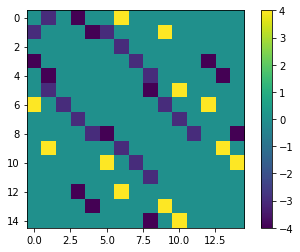

In [5]:
H.imshow()

In [6]:
H.printstates()

Printing our states and their indexing numbers.
The first  2  entries represent the up electrons.
The last  0  entries represent the down electrons.
Each number gives the site number of the corresponding electron (from 0 to  6 including endpoints).
[0, 1] 0
[0, 2] 1
[0, 3] 2
[0, 4] 3
[0, 5] 4
[1, 2] 5
[1, 3] 6
[1, 4] 7
[1, 5] 8
[2, 3] 9
[2, 4] 10
[2, 5] 11
[3, 4] 12
[3, 5] 13
[4, 5] 14


In [7]:
H.printbasis()

Printing our basis elements and their indexing numbers.
The first  6  entries represent the presence of an up electron on the corresponding site or not.
The last  6  entries represent the presence of a down electron on the corresponding site or not.
[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] 0
[1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0] 1
[1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0] 2
[1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0] 3
[1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0] 4
[0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0] 5
[0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0] 6
[0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0] 7
[0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0] 8
[0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0] 9
[0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0] 10
[0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0] 11
[0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0] 12
[0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0] 13
[0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0] 14
